Epoch 50/50| mse:  135.10: 100%|██████████| 50/50 [00:00<00:00, 170.95it/s]


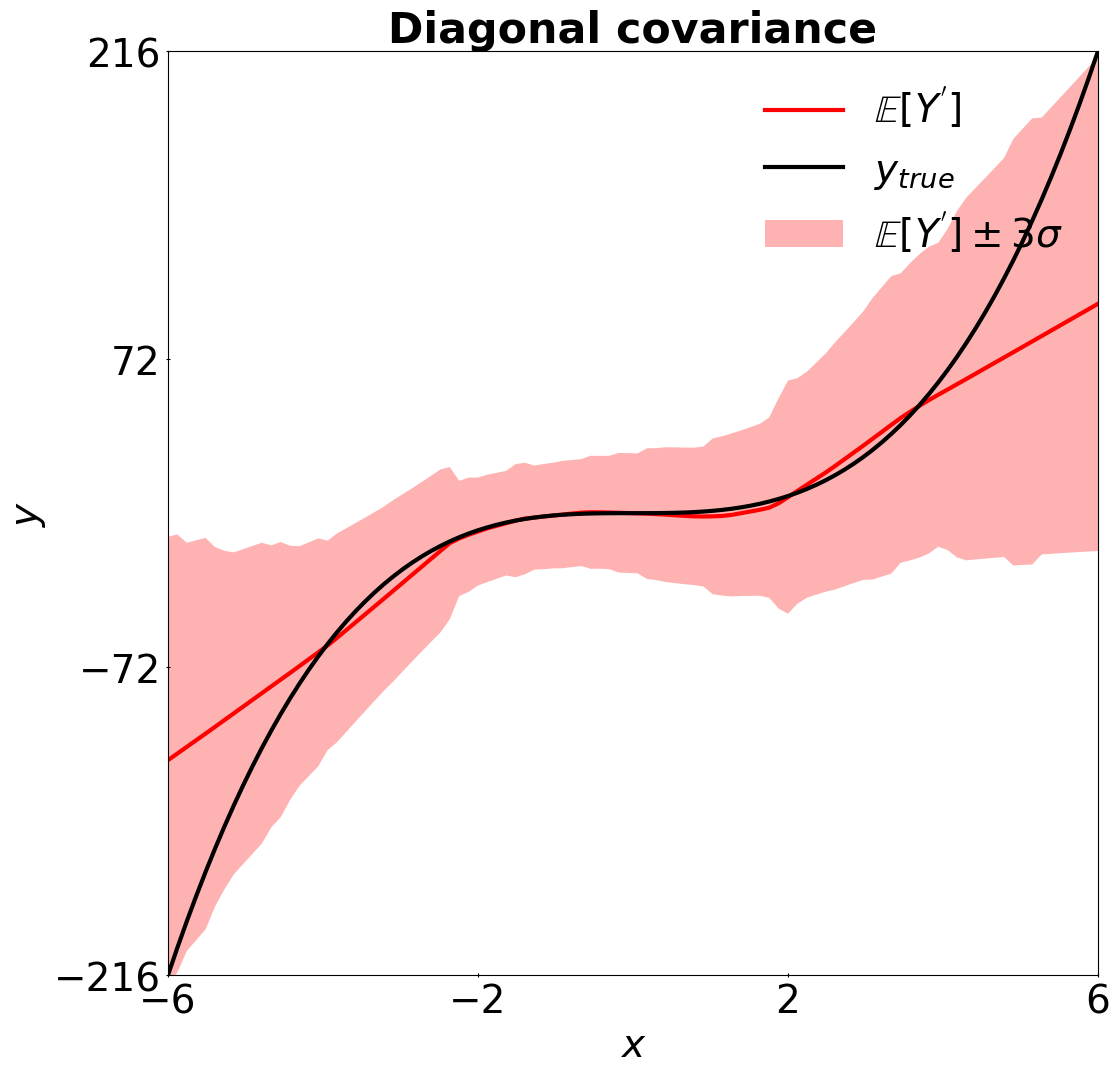

#############
MSE           :  1167.81
Log-likelihood: -4.28


In [1]:
import fire
import numpy as np
from tqdm import tqdm

import pytagi.metric as metric
from examples.data_loader import RegressionDataLoader
from examples.time_series_forecasting import PredictionViz
from pytagi import Normalizer
from pytagi.nn import Linear, OutputUpdater, ReLU, Sequential

import os
# CHANGE THIS TO YOUR OWN PATH TO cuTAGI
os.chdir('/Users/zhanwenxin/Documents/GitHub/cuTAGI-LSTM')

num_epochs = 50
batch_size = 10
sigma_v = 0.2

"""Run training for the regression"""
# Dataset
x_train_file = "./data/toy_example/x_train_1D.csv"
y_train_file = "./data/toy_example/y_train_1D.csv"
x_test_file = "./data/toy_example/x_test_1D.csv"
y_test_file = "./data/toy_example/y_test_1D.csv"

train_dtl = RegressionDataLoader(x_file=x_train_file, y_file=y_train_file)
test_dtl = RegressionDataLoader(
    x_file=x_test_file,
    y_file=y_test_file,
    x_mean=train_dtl.x_mean,
    x_std=train_dtl.x_std,
    y_mean=train_dtl.y_mean,
    y_std=train_dtl.y_std,
)

# Viz
viz = PredictionViz(task_name="regression", data_name="1d_toy")

# Network
net = Sequential(
    Linear(1, 50),
    ReLU(),
    Linear(50, 50),
    ReLU(),
    Linear(50, 1),
)

# net.to_device("cuda")
# net.set_threads(8)

out_updater = OutputUpdater(net.device)
var_y = np.full((batch_size,), sigma_v**2, dtype=np.float32)

# -------------------------------------------------------------------------#
# Training
mses = []
pbar = tqdm(range(num_epochs), desc="Training Progress")
for epoch in pbar:
    batch_iter = train_dtl.create_data_loader(batch_size)

    for x, y in batch_iter:
        # Feed forward
        m_pred, _ = net(x)

        # Update output layer
        out_updater.update(
            output_states=net.output_z_buffer,
            mu_obs=y,
            var_obs=var_y,
            delta_states=net.input_delta_z_buffer,
        )

        # Feed backward
        net.backward()
        net.step()

        # Training metric
        pred = Normalizer.unstandardize(m_pred, train_dtl.y_mean, train_dtl.y_std)
        obs = Normalizer.unstandardize(y, train_dtl.y_mean, train_dtl.y_std)
        mse = metric.mse(pred, obs)
        mses.append(mse)

    # Progress bar
    pbar.set_description(
        f"Epoch {epoch + 1}/{num_epochs}| mse: {sum(mses)/len(mses):>7.2f}",
        refresh=True,
    )

# -------------------------------------------------------------------------#
# Testing
net.eval()
test_batch_iter = test_dtl.create_data_loader(batch_size, shuffle=False)
mu_preds = []
var_preds = []
y_test = []
x_test = []

for x, y in test_batch_iter:
    # Predicion
    m_pred, v_pred = net(x)

    mu_preds.extend(m_pred)
    var_preds.extend(v_pred + sigma_v**2)
    x_test.extend(x)
    y_test.extend(y)

mu_preds = np.array(mu_preds)
std_preds = np.array(var_preds) ** 0.5
y_test = np.array(y_test)
x_test = np.array(x_test)

mu_preds = Normalizer.unstandardize(mu_preds, train_dtl.y_mean, train_dtl.y_std)
std_preds = Normalizer.unstandardize_std(std_preds, train_dtl.y_std)

x_test = Normalizer.unstandardize(x_test, train_dtl.x_mean, train_dtl.x_std)
y_test = Normalizer.unstandardize(y_test, train_dtl.y_mean, train_dtl.y_std)

# Compute log-likelihood
mse = metric.mse(mu_preds, y_test)
log_lik = metric.log_likelihood(
    prediction=mu_preds, observation=y_test, std=std_preds
)

# Visualization
viz.plot_predictions(
    x_train=None,
    y_train=None,
    x_test=x_test,
    y_test=y_test,
    y_pred=mu_preds,
    sy_pred=std_preds,
    std_factor=3,
    label="diag",
    title="Diagonal covariance",
)

print("#############")
print(f"MSE           : {mse: 0.2f}")
print(f"Log-likelihood: {log_lik: 0.2f}")



In [2]:
net.save_csv("./saved_param/regression_test/regression_model")

In [3]:
def multiply_model_by_ratio(model_path, TAU):
    import csv
    # Remove the .csv in a string and add "_1_mw.csv" to the end
    model_path1 = model_path[:-4] + "_1_mw.csv"
    model_path2 = model_path[:-4] + "_2_Sw.csv"
    model_path3 = model_path[:-4] + "_3_mb.csv"
    model_path4 = model_path[:-4] + "_4_Sb.csv"

    # Read the csv file and store them in four variables
    param1 = np.genfromtxt(model_path1, delimiter=',', skip_header=0)
    param2 = np.genfromtxt(model_path2, delimiter=',', skip_header=0)
    param3 = np.genfromtxt(model_path3, delimiter=',', skip_header=0)
    param4 = np.genfromtxt(model_path4, delimiter=',', skip_header=0)

    # Multiply the parameters by the ratio TAU
    param1 = param1 * TAU
    param2 = param2 * TAU
    param3 = param3 * TAU
    param4 = param4 * TAU

    # Write the new parameters to the csv file
    with open(model_path[:-4] + "_temp_1_mw.csv", mode='w') as file:
        writer = csv.writer(file)
        for value in param1:
            writer.writerow([value])
    with open(model_path[:-4] + "_temp_2_Sw.csv", mode='w') as file:
        writer = csv.writer(file)
        for value in param2:
            writer.writerow([value])
    with open(model_path[:-4] + "_temp_3_mb.csv", mode='w') as file:
        writer = csv.writer(file)
        for value in param3:
            writer.writerow([value])
    with open(model_path[:-4] + "_temp_4_Sb.csv", mode='w') as file:
        writer = csv.writer(file)
        for value in param4:
            writer.writerow([value])

In [4]:
net_load = Sequential(
    Linear(1, 50),
    ReLU(),
    Linear(50, 50),
    ReLU(),
    Linear(50, 1),
)

multiply_model_by_ratio("./saved_param/regression_test/regression_model.csv", 1)

mu_w, var_w, mu_b, var_b = net.get_params()
net_load.load_params(mu_w, var_w, mu_b, var_b)

In [5]:
print(mu_w.shape)
print(mu_b.shape)
print(var_w.shape)
print(var_b.shape)

(2600,)
(101,)
(2600,)
(101,)


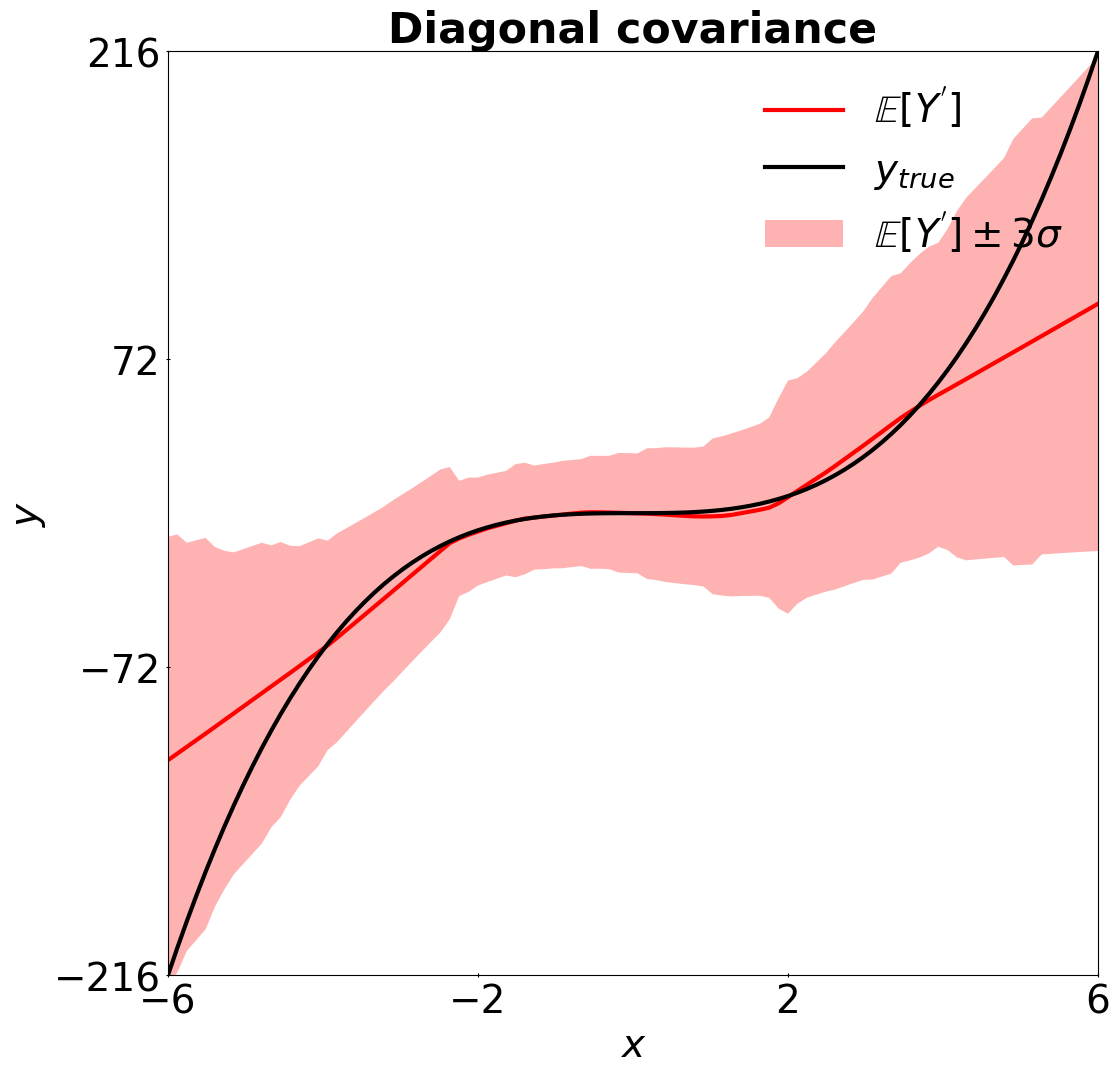

In [6]:
test_batch_iter = test_dtl.create_data_loader(batch_size, shuffle=False)
mu_preds = []
var_preds = []
y_test = []
x_test = []

for x, y in test_batch_iter:
    # Predicion
    m_pred, v_pred = net_load(x)

    mu_preds.extend(m_pred)
    var_preds.extend(v_pred + sigma_v**2)
    x_test.extend(x)
    y_test.extend(y)

mu_preds = np.array(mu_preds)
std_preds = np.array(var_preds) ** 0.5
y_test = np.array(y_test)
x_test = np.array(x_test)

mu_preds = Normalizer.unstandardize(mu_preds, train_dtl.y_mean, train_dtl.y_std)
std_preds = Normalizer.unstandardize_std(std_preds, train_dtl.y_std)

x_test = Normalizer.unstandardize(x_test, train_dtl.x_mean, train_dtl.x_std)
y_test = Normalizer.unstandardize(y_test, train_dtl.y_mean, train_dtl.y_std)

# Compute log-likelihood
mse = metric.mse(mu_preds, y_test)
log_lik = metric.log_likelihood(
    prediction=mu_preds, observation=y_test, std=std_preds
)

# Visualization
viz.plot_predictions(
    x_train=None,
    y_train=None,
    x_test=x_test,
    y_test=y_test,
    y_pred=mu_preds,
    sy_pred=std_preds,
    std_factor=3,
    label="diag",
    title="Diagonal covariance",
)